In [1]:
import nipype
import nipype.interfaces.utility as niu
import nipype.interfaces.io as nio
from nipype.interfaces import fsl, freesurfer, ants
from nipype.pipeline import engine as pe

import os

220308-10:31:03,752 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.0


In [2]:
subject_ids = [str(x).zfill(2) for x in range(1,20)]
subject_ids

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

## PCA in MNI space

In [3]:
import glob
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import scipy as sp
from scipy import ndimage

import nilearn
from nilearn import image, plotting

import nighres
from nighres import registration

import matplotlib.pyplot as plt

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning:




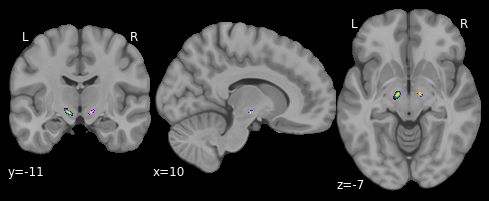

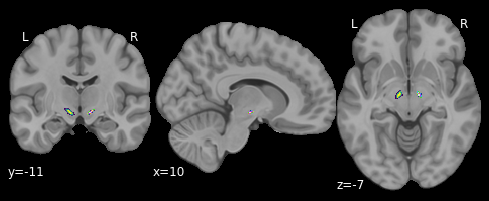

In [2]:
# what do the mean STN images look like in MNI space?
for ds in ['01', '02']:
    mean_stnr = image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped/sub-*/sub-*_space-MNI152NLin2009cAsym_desc-stnr_mask.nii.gz'))
    mean_stnl = image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped/sub-*/sub-*_space-MNI152NLin2009cAsym_desc-stnl_mask.nii.gz'))
    mean_stnr.to_filename(f'./derivatives/ds-{ds}/MNI_group_space/mean_stnr.nii.gz')
    mean_stnl.to_filename(f'./derivatives/ds-{ds}/MNI_group_space/mean_stnl.nii.gz')
    
    disp = plotting.plot_roi(mean_stnr, bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii', draw_cross=False)
    disp.add_overlay(mean_stnl)

In [5]:
for ds in ['01', '02']:    
    for hemisphere in ['l', 'r']:
        
        mask_fns = sorted(glob.glob(f'./derivatives/ds-{ds}/masks_warped/sub-*/sub-*_space-MNI152NLin2009cAsym_desc-stn{hemisphere}_mask.nii.gz'))

        images = [nib.load(fn) for fn in mask_fns]
        masks = [image.get_fdata() for image in images]

        threshold = 0.9 * len(masks)

        summed_masks =  np.sum(masks, 0)
        x, y, z = np.where((summed_masks > threshold))

        coords = pd.DataFrame({'x':x, 'y':y, 'z':z})
        coords -= coords.mean()

        pca = PCA(n_components=1)
        pca.fit(coords)

        # Make sure it goes inferior
        if pca.components_[0, -1] > 0:
            pca.components_ *= -1

        transformed_coordinates = pca.transform(np.array(np.where(np.ones_like(summed_masks))).T)
        new_data = transformed_coordinates.ravel() + transformed_coordinates.min() + 1
        new_data = new_data.reshape(summed_masks.shape)

        ## save
        os.makedirs(f'./derivatives/ds-{ds}/MNI_group_space', exist_ok=True)
        nib.save(nib.Nifti1Image(new_data, images[0].affine), f'./derivatives/ds-{ds}/MNI_group_space/stn_{hemisphere}_pca.nii.gz')
        nib.save(nib.Nifti1Image(summed_masks, images[0].affine), f'./derivatives/ds-{ds}/MNI_group_space/group_stn_{hemisphere}.nii.gz')

# Visualize PCA

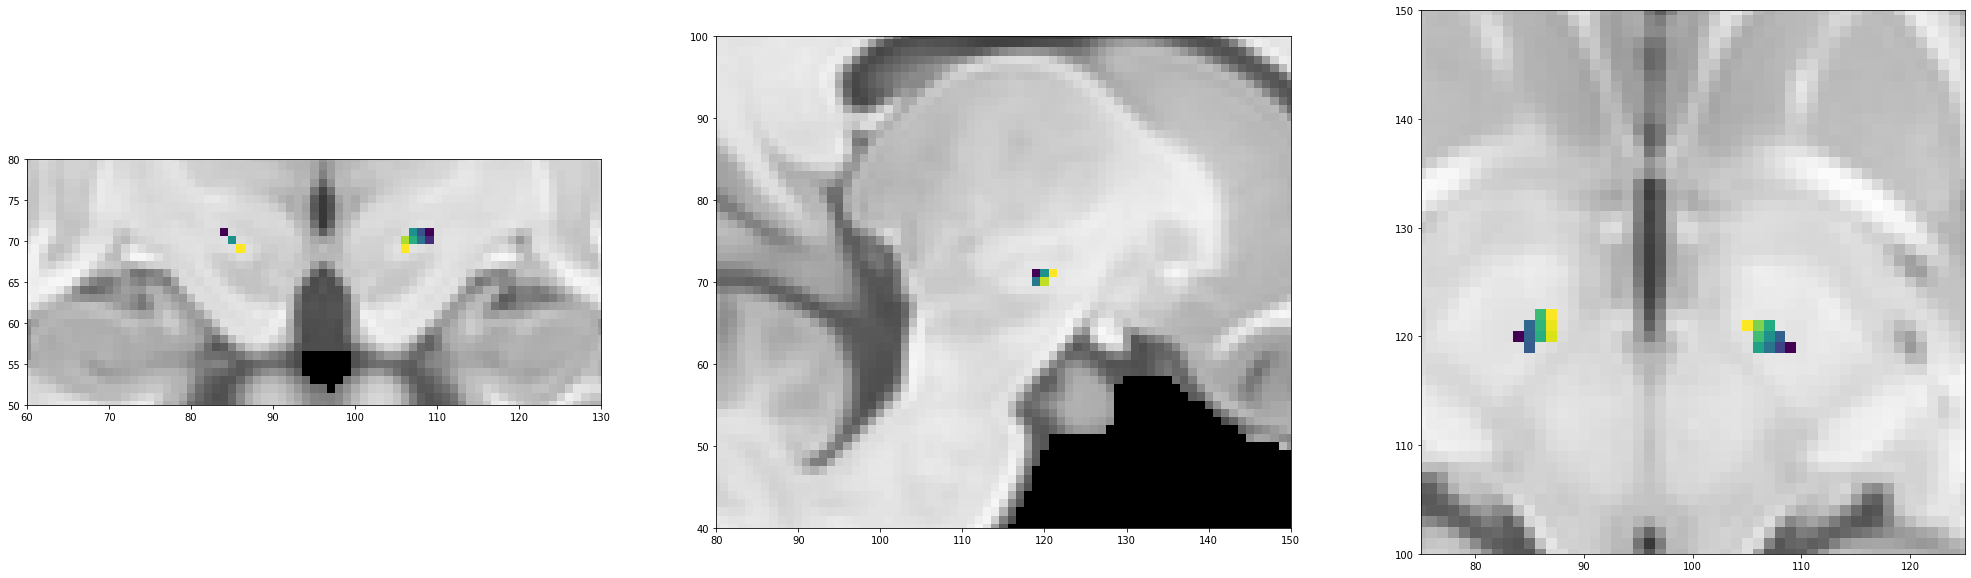

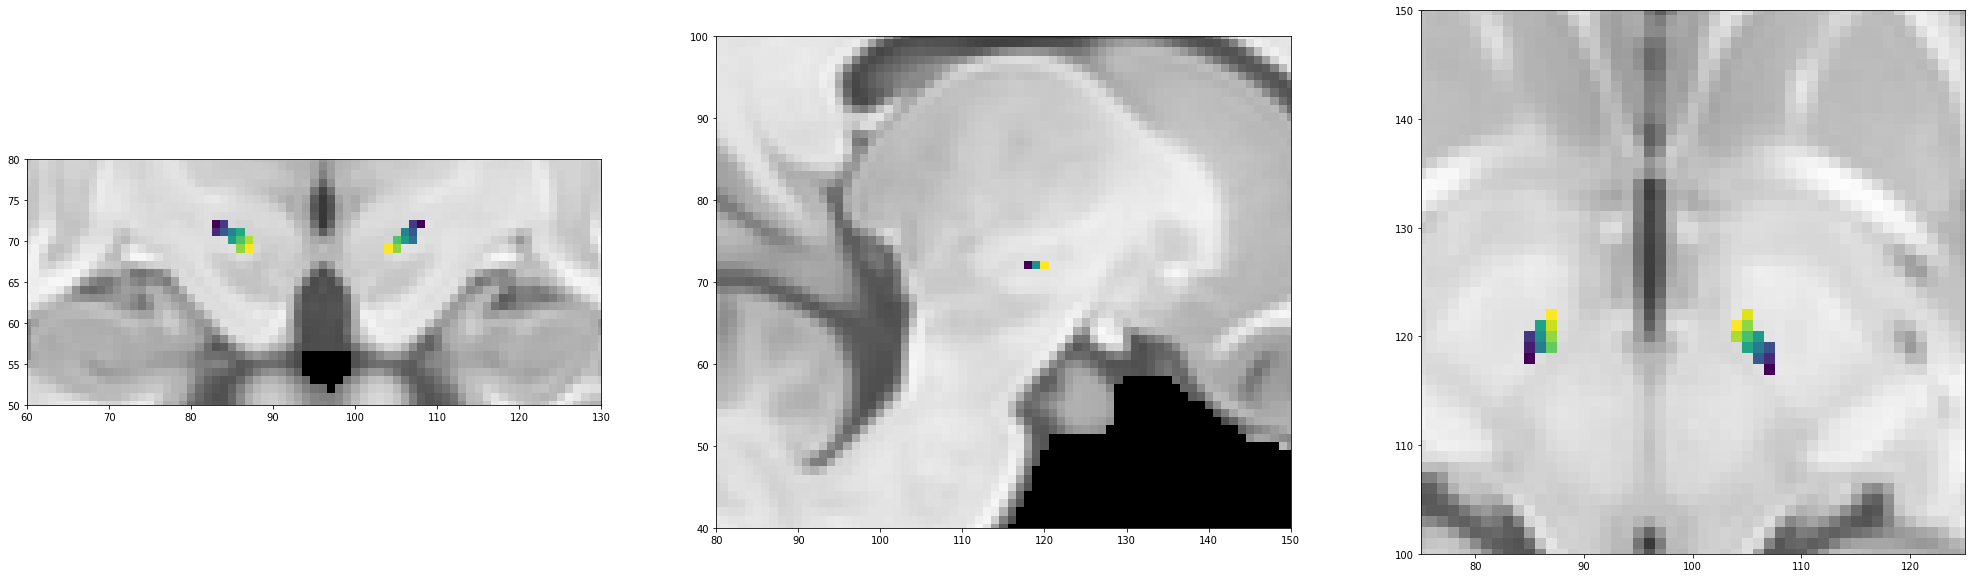

In [6]:
##
group_image = nib.load('/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii').get_fdata()

for ds in ['01', '02']:    
    left_stn = nib.load(f'./derivatives/ds-{ds}/MNI_group_space/group_stn_l.nii.gz').get_fdata()
    right_stn = nib.load(f'./derivatives/ds-{ds}/MNI_group_space/group_stn_r.nii.gz').get_fdata()

    pca_map_stn_l = nib.load(f'./derivatives/ds-{ds}/MNI_group_space/stn_l_pca.nii.gz').get_fdata()
    pca_map_stn_r = nib.load(f'./derivatives/ds-{ds}/MNI_group_space/stn_r_pca.nii.gz').get_fdata()
    
    com_l = ndimage.center_of_mass(left_stn)
    com_l = np.array(com_l).astype(int)
    
    pca_map_stn_l_masked = pca_map_stn_l.copy()
    pca_map_stn_l_masked[left_stn < .8*left_stn.max()] = 0
    pca_map_stn_l_masked = np.ma.masked_equal(pca_map_stn_l_masked, 0)

    pca_map_stn_r_masked = pca_map_stn_r.copy()
    pca_map_stn_r_masked[right_stn < .8*right_stn.max()] = 0
    pca_map_stn_r_masked = np.ma.masked_equal(pca_map_stn_r_masked, 0)

    plt.figure(figsize=(35, 10))
    plt.subplot(131)
    plt.imshow(group_image[::-1, 119, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
    plt.imshow(pca_map_stn_l_masked[::-1, 119, :].T, origin='lower', cmap=plt.cm.viridis)
    plt.imshow(pca_map_stn_r_masked[::-1, 119, :].T, origin='lower', cmap=plt.cm.viridis)
    plt.xlim(60, 130)
    plt.ylim(50, 80)

    plt.subplot(132)
    plt.imshow(group_image[84, :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
    plt.imshow(pca_map_stn_l_masked[84, :, :].T, origin='lower', cmap=plt.cm.viridis)
    plt.imshow(pca_map_stn_r_masked[84, :, :].T, origin='lower', cmap=plt.cm.viridis)
    plt.xlim(80, 150)
    plt.ylim(40, 100)

    plt.subplot(133)
    plt.imshow(group_image[::-1, :, 70].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
    plt.imshow(pca_map_stn_l_masked[::-1, :, 70].T, origin='lower', cmap=plt.cm.viridis)
    plt.imshow(pca_map_stn_r_masked[::-1, :, 70].T, origin='lower', cmap=plt.cm.viridis)
    plt.xlim(75, 125)
    plt.ylim(100, 150)

## Warp PCA masks to T1w-space

In [ ]:
def warp_pca_masks_to_t1w(ds):
    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]

    project_folder = '/home/stevenm/Projects/bias'
    workflow = pe.Workflow(name='PCA_to_individual_t1w_ds{}'.format(ds))
    workflow.base_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders')
    workflow.config = {"execution": {"crashdump_dir":os.path.join(project_folder, 'processing', 'crashdumps')}}

    templates = {'pca': os.path.join(project_folder, f'./derivatives/ds-{ds}/MNI_group_space/stn_{{hemisphere}}_pca.nii.gz'),
                 'transformation_matrix': os.path.join(project_folder, f'./derivatives/ds-{ds}/fmriprep/sub-{{subject_id}}/anat/sub-{{subject_id}}_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5'),
                 't1w': os.path.join(project_folder, 'derivatives', f'ds-{ds}', 'fmriprep', 'sub-{subject_id}',  'anat',  'sub-{subject_id}_desc-preproc_T1w.nii.gz')
                }
    selector = pe.Node(nio.SelectFiles(templates), name='selector')
    selector.iterables = [('subject_id', subject_ids), ('hemisphere', ['l', 'r'])]

    
    transformer = pe.Node(ants.ApplyTransforms(), name='applier')
    workflow.connect(selector, 'pca', transformer, 'input_image')
    workflow.connect(selector, 'transformation_matrix', transformer, 'transforms')
    workflow.connect(selector, 't1w', transformer, 'reference_image')

    datasink = pe.Node(nio.DataSink(), name='datasink')
    datasink.inputs.base_directory = os.path.join(project_folder, 'derivatives', f'ds-{ds}')
    workflow.connect(transformer, 'output_image', datasink, 'pca_in_t1w')

    datasink.inputs.regexp_substitutions = [#('PCA_segments/pca_in_t1w', f'derivatives/ds-{ds}/PCA_segments/'), 
                                      ('pca_in_t1w/_hemisphere_[a-z]_subject_id_([0-9]+)/stn_([a-z])_pca_trans.nii.gz', 'PCA_segments/sub-\\1/sub-\\1_space-T1w_desc-stn-\\2_pca.nii.gz')]

    workflow.run(plugin='MultiProc', plugin_args={'n_procs': 10, 'memory_gb': 250})    # should be fast

for ds in ['02', '01']:
    warp_pca_masks_to_t1w(ds)

220306-14:54:17,671 nipype.workflow INFO:
	 Workflow PCA_to_individual_t1w_ds02 settings: ['check', 'execution', 'logging', 'monitoring']
220306-14:54:17,761 nipype.workflow INFO:
	 Running in parallel.
220306-14:54:17,767 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 28 jobs ready. Free memory (GB): 250.00/250.00, Free processors: 10/10.
220306-14:54:18,174 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_t1w_ds02.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA_to_individual_t1w_ds02/_hemisphere_r_subject_id_15/selector".
220306-14:54:18,175 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_t1w_ds02.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA_to_individual_t1w_ds02/_hemisphere_l_subject_id_15/selector".
220306-14:54:18,177 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_t1w_ds02.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA_to_individu

#### and for ds-01 also to FLASH space

In [ ]:
def warp_pca_masks_to_flash(ds='01'):
    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]

    project_folder = '/home/stevenm/Projects/bias'
    workflow = pe.Workflow(name='PCA_to_individual_flash_ds{}'.format(ds))
    workflow.base_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders')
    workflow.config = {"execution": {"crashdump_dir":os.path.join(project_folder, 'processing', 'crashdumps')}}

    templates = {'pca': os.path.join(project_folder, f'./derivatives/ds-{ds}/MNI_group_space/stn_{{hemisphere}}_pca.nii.gz'),
                 'mni_to_t1w': os.path.join(project_folder, f'./derivatives/ds-{ds}/fmriprep/sub-{{subject_id}}/anat/sub-{{subject_id}}_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5'),
                 't1w_to_flash': os.path.join(project_folder, './derivatives/ds-01/coregister_flash_to_t1w/sub-{subject_id}/sub-{subject_id}_from-T1w_to-FLASH_mode-image_xfm.txt'),
                 'flash_echo1': os.path.join(project_folder, 'sourcedata', 'sourcedata', 'ds-01', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_echo-1_FLASH.nii.gz'),
                }
    selector = pe.Node(nio.SelectFiles(templates), name='selector')
    selector.iterables = [('subject_id', subject_ids), ('hemisphere', ['l', 'r'])]

    merger = pe.Node(niu.Merge(2), 'warp_merger')
    workflow.connect(selector, 'mni_to_t1w', merger, 'in2')  # note that transforms are inputted in 'reverse order'
    workflow.connect(selector, 't1w_to_flash', merger, 'in1')

    transformer = pe.Node(ants.ApplyTransforms(), name='applier')
    workflow.connect(selector, 'pca', transformer, 'input_image')
    workflow.connect(merger, 'out', transformer, 'transforms')
    workflow.connect(selector, 'flash_echo1', transformer, 'reference_image')

    
    datasink = pe.Node(nio.DataSink(), name='datasink')
    datasink.inputs.base_directory = os.path.join(project_folder, 'derivatives', f'ds-{ds}')
    workflow.connect(transformer, 'output_image', datasink, 'pca_in_flash')

    datasink.inputs.regexp_substitutions = [#('PCA_segments/pca_in_t1w', f'derivatives/ds-{ds}/PCA_segments/'), 
                                            ('pca_in_flash/_hemisphere_[a-z]_subject_id_([0-9]+)/stn_([a-z])_pca_trans.nii.gz', 'PCA_segments/sub-\\1/sub-\\1_space-FLASH_desc-stn-\\2_pca.nii.gz')]

    workflow.run(plugin='MultiProc', plugin_args={'n_procs': 10, 'memory_gb': 250})    # should be fast

warp_pca_masks_to_flash('01')

220308-10:24:11,961 nipype.workflow INFO:
	 Workflow PCA_to_individual_flash_ds01 settings: ['check', 'execution', 'logging', 'monitoring']
220308-10:24:12,102 nipype.workflow INFO:
	 Running in parallel.
220308-10:24:12,110 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 38 jobs ready. Free memory (GB): 250.00/250.00, Free processors: 10/10.
220308-10:24:12,690 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_flash_ds01.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA_to_individual_flash_ds01/_hemisphere_l_subject_id_19/selector".
220308-10:24:12,690 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_flash_ds01.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA_to_individual_flash_ds01/_hemisphere_r_subject_id_19/selector".
220308-10:24:12,691 nipype.workflow INFO:
	 [Node] Setting-up "PCA_to_individual_flash_ds01.selector" in "/home/stevenm/Projects/bias/processing/nipype_workflow_folders/PCA

## Make individual STN segments

In [4]:
for ds in ['01', '02']:
    print(ds)
    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    space_name = 'T1w' if ds == '01' else 'T1w-RAS'
    for subj_idx in subject_ids:
        print(subj_idx)

        ## *** Left stn ***
        pca_left_stn = nib.load(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn-l_pca.nii.gz')
        left_stn = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space_name}_desc-stnl_mask.nii.gz')

        com = ndimage.center_of_mass(left_stn.get_fdata())
        pca_values = pca_left_stn.get_fdata()[left_stn.get_fdata() > 0]

        pca_values_3d = np.ones_like(left_stn.get_fdata()) * np.nan
        pca_values_3d[left_stn.get_fdata() > 0] = pca_values

        segment_a = np.zeros_like(left_stn.get_fdata())
        segment_a = (left_stn.get_fdata() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

        segment_b = np.zeros_like(left_stn.get_fdata())
        segment_b = (left_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        segment_c = np.zeros_like(left_stn.get_fdata())
        segment_c = (left_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        print(segment_a.sum(), segment_b.sum(), segment_c.sum())

        nib.save(nib.Nifti1Image(segment_a.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-A.nii.gz')
        nib.save(nib.Nifti1Image(segment_b.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-B.nii.gz')
        nib.save(nib.Nifti1Image(segment_c.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-C.nii.gz')

        ## *** Right stn ***
        pca_right_stn = nib.load(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn-r_pca.nii.gz')
        right_stn = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space_name}_desc-stnr_mask.nii.gz')
        
        com = ndimage.center_of_mass(right_stn.get_fdata())
        pca_values = pca_right_stn.get_fdata()[right_stn.get_fdata() > 0]

        pca_values_3d = np.ones_like(right_stn.get_fdata()) * np.nan
        pca_values_3d[right_stn.get_fdata() > 0] = pca_values

        segment_a = np.zeros_like(right_stn.get_fdata())
        segment_a = (right_stn.get_fdata() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

        segment_b = np.zeros_like(right_stn.get_fdata())
        segment_b = (right_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        segment_c = np.zeros_like(right_stn.get_fdata())
        segment_c = (right_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        print(segment_a.sum(), segment_b.sum(), segment_c.sum())

        nib.save(nib.Nifti1Image(segment_a.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-A.nii.gz')
        nib.save(nib.Nifti1Image(segment_b.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-B.nii.gz')
        nib.save(nib.Nifti1Image(segment_c.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-C.nii.gz')

01
01
75 74 75
75 75 75
02
54 53 54
71 71 71
03
52 52 53
67 66 67
04
48 48 48
56 56 56
05
45 45 46
50 50 50
06
53 53 53
48 48 49
07
55 54 55
52 52 53
08
28 28 28
58 58 58
09
60 60 60
78 77 78
10
53 52 53
70 70 71
11
63 62 63
53 53 53
12
38 37 38
46 46 47
13
55 55 55
42 42 42
14
40 39 40
44 44 45
15
29 29 30
40 40 41
16
46 46 47
38 38 39
17
60 60 61
52 52 52
18
81 80 81
64 63 64
19
56 56 56
75 75 76
02
01
86 87 86
136 136 136
02
117 117 118
120 120 120
03
79 79 79
90 89 90
05
101 101 102
112 112 113
06
50 50 51
55 54 55
07
81 80 81
86 86 87
08
107 107 107
110 109 110
09
117 117 117
115 115 115
10
104 103 104
100 99 100
11
85 85 86
56 55 56
12
75 74 75
88 88 89
13
96 96 96
98 98 98
14
101 101 102
141 140 141
15
98 98 99
84 83 84


### Make subrois in FLASH space as well (for plotting purposes only)

In [13]:
for ds in ['01']:
    print(ds)
    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    space_name = 'FLASH' 
    for subj_idx in subject_ids:
        print(subj_idx)

        ## *** Left stn ***
        pca_left_stn = nib.load(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stn-l_pca.nii.gz')
        left_stn = nib.load(f'./derivatives/ds-{ds}/conjunct_masks/sub-{subj_idx}/anat/sub-{subj_idx}_space-FLASH_desc-stnl_mask.nii.gz')

        com = ndimage.center_of_mass(left_stn.get_fdata())
        pca_values = pca_left_stn.get_fdata()[left_stn.get_fdata() > 0]

        pca_values_3d = np.ones_like(left_stn.get_fdata()) * np.nan
        pca_values_3d[left_stn.get_fdata() > 0] = pca_values

        segment_a = np.zeros_like(left_stn.get_fdata())
        segment_a = (left_stn.get_fdata() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

        segment_b = np.zeros_like(left_stn.get_fdata())
        segment_b = (left_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        segment_c = np.zeros_like(left_stn.get_fdata())
        segment_c = (left_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        print(segment_a.sum(), segment_b.sum(), segment_c.sum())

        nib.save(nib.Nifti1Image(segment_a.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnl_subroi-A.nii.gz')
        nib.save(nib.Nifti1Image(segment_b.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnl_subroi-B.nii.gz')
        nib.save(nib.Nifti1Image(segment_c.astype(float), left_stn.affine, left_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnl_subroi-C.nii.gz')

        ## *** Right stn ***
        pca_right_stn = nib.load(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stn-r_pca.nii.gz')
        right_stn = nib.load(f'./derivatives/ds-{ds}/conjunct_masks/sub-{subj_idx}/anat/sub-{subj_idx}_space-FLASH_desc-stnr_mask.nii.gz')
        
        com = ndimage.center_of_mass(right_stn.get_fdata())
        pca_values = pca_right_stn.get_fdata()[right_stn.get_fdata() > 0]

        pca_values_3d = np.ones_like(right_stn.get_fdata()) * np.nan
        pca_values_3d[right_stn.get_fdata() > 0] = pca_values

        segment_a = np.zeros_like(right_stn.get_fdata())
        segment_a = (right_stn.get_fdata() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

        segment_b = np.zeros_like(right_stn.get_fdata())
        segment_b = (right_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        segment_c = np.zeros_like(right_stn.get_fdata())
        segment_c = (right_stn.get_fdata() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

        print(segment_a.sum(), segment_b.sum(), segment_c.sum())

        nib.save(nib.Nifti1Image(segment_a.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnr_subroi-A.nii.gz')
        nib.save(nib.Nifti1Image(segment_b.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnr_subroi-B.nii.gz')
        nib.save(nib.Nifti1Image(segment_c.astype(float), right_stn.affine, right_stn.header), f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-FLASH_desc-stnr_subroi-C.nii.gz')

01
01
202 202 203
207 206 207
02
147 147 147
197 197 197
03
152 152 152
188 188 189
04
130 130 131
155 155 155
05
131 131 132
137 137 137
06
145 145 145
137 137 138
07
144 144 144
149 149 150
08
74 74 74
160 160 160
09
167 166 167
205 205 205
10
146 146 146
187 187 188
11
172 172 172
150 150 151
12
106 106 106
132 132 133
13
149 149 149
116 116 117
14
106 105 106
121 121 122
15
82 81 82
108 108 109
16
130 130 130
103 103 103
17
159 159 159
136 135 136
18
214 214 214
175 175 175
19
154 154 155
209 209 209


In [5]:
## are the masks bigger in ds-02?
all_mask_sizes = []
for ds in ['01', '02']:
    print(ds)
    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    mask_fn = 'sub-{subj_idx}_space-FLASH_desc-stn{hemisphere}_mask.nii.gz' if ds == '01' else 'sub-{subj_idx}_desc-stn{hemisphere}_mask.nii.gz'
    voxvol = 0.5**3 if ds == '01' else (0.7*0.641*0.641)
    for subj_idx in subject_ids:
        for hemisphere in ['l', 'r']:
            volume = nib.load(f'./derivatives/ds-{ds}/conjunct_masks/sub-{subj_idx}/anat/' + mask_fn.format(subj_idx=subj_idx, hemisphere=hemisphere)).get_fdata().sum() * voxvol
        
            all_mask_sizes.append(pd.DataFrame({'ds': ds, 'sub': subj_idx, 'hemisphere': hemisphere, 'volume': volume}, index=[0]))


01
02


In [6]:
pd.concat(all_mask_sizes).groupby(['ds', 'hemisphere'])['volume'].mean()

ds  hemisphere
01  l             53.493421
    r             58.703947
02  l             80.019075
    r             85.648144
Name: volume, dtype: float64

#### so we have substantially larger STNs in the second dataset
More partial voluming?

# And plot, with mean FLASH or T2* as background

Note that we resample the background image here; this is only for visualization purposes

In [14]:
# ## first warp PCA masks to FLASH space
# def warp_pca_masks_to_flash(ds='01'):
#     subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]

#     project_folder = '/home/stevenm/Projects/bias'
#     workflow = pe.Workflow(name='PCA_to_individual_flash_ds{}'.format(ds))
#     workflow.base_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders')
#     workflow.config = {"execution": {"crashdump_dir":os.path.join(project_folder, 'processing', 'crashdumps')}}

#     templates = {'mask': os.path.join(project_folder, './derivatives/ds-01/masks_warped/sub-{subject_id}/sub-{subject_id}_space-T1w_desc-stn{hemisphere}_subroi-{subroi}.nii.gz'),
#                  # 'mni_to_t1w': os.path.join(project_folder, f'./derivatives/ds-{ds}/fmriprep/sub-{{subject_id}}/anat/sub-{{subject_id}}_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5'),
#                  't1w_to_flash': os.path.join(project_folder, './derivatives/ds-01/coregister_flash_to_t1w/sub-{subject_id}/sub-{subject_id}_from-T1w_to-FLASH_mode-image_xfm.txt'),
#                  'flash_echo1': os.path.join(project_folder, 'sourcedata', 'sourcedata', 'ds-01', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_echo-1_FLASH.nii.gz'),
#                 }
#     selector = pe.Node(nio.SelectFiles(templates), name='selector')
#     selector.iterables = [('subject_id', subject_ids), ('hemisphere', ['l', 'r']), ('subroi', ['A', 'B', 'C'])]

    
#     apply_syn = pe.Node(ants.ApplyTransforms(), name='applysyn_mni_2_flash', iterfield='input_image')
#     apply_syn.inputs.interpolation = 'NearestNeighbor'
#     workflow.connect(selector, 't1w_to_flash', apply_syn, 'transforms')
#     workflow.connect(selector, 'mask', apply_syn, 'input_image')
#     workflow.connect(selector, 'flash_echo1', apply_syn, 'reference_image')

    
#     ##
#     ds = pe.Node(nio.DataSink(), name='datasink')
#     ds.inputs.base_directory = os.path.join(project_folder, 'derivatives', 'ds-01', 'masks_warped')
#     ds.inputs.regexp_substitutions = [(r'masks_warped/FLASH/_hemisphere_[a-z]_subject_id_([0-9]{2})_subroi_[A-Z]/', 'masks_warped/sub-\\1/'),
#                                       ('sub-([0-9]{2})_space-T1w_desc-stn([a-z])_subroi-([A-Z])_trans.nii.gz', 'sub-\\1_space-FLASH_desc-stn\\2_subroi-\\3.nii.gz')
#                                      ]

#     workflow.connect(apply_syn, 'output_image', ds, 'FLASH')
    
#     workflow.run(plugin='MultiProc', plugin_args={'n_procs': 10, 'memory_gb': 250})    # should be fast

# warp_pca_masks_to_flash('01')

In [15]:
def to_ras(orig_img):
    from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff
    
    # # Find transform from current (approximate) orientation to
    # # target, in nibabel orientation matrix and affine forms
    orig_ornt = nib.io_orientation(orig_img.affine)
    targ_ornt = axcodes2ornt('RAS')
    transform = ornt_transform(orig_ornt, targ_ornt)
    affine_xfm = inv_ornt_aff(transform, orig_img.shape)

    # # Check can be eliminated when minimum nibabel version >= 2.4
    reoriented = orig_img.as_reoriented(transform)
    return reoriented

In [16]:
import seaborn as sns
import matplotlib.gridspec as gridspec

In [17]:
def plot_slice(bg_data, segments_data, slices, ax, vmax,
               segment_colors=['blue', 'green', 'red', 'blue', 'green', 'red'], 
               plot_contour=False, **plot_kwargs):
    ax.imshow(bg_data[slices[0], slices[1], slices[2]].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)
    
    for segment, color in zip(segments_data, segment_colors):
        if plot_contour:
            ax.contour(segment[slices[0], slices[1], slices[2]].T, origin='lower', colors=color, levels=[0, 1], corner_mask=False, **plot_kwargs)
        else:
            # ax.imshow(segment[slices[0], slices[1], slices[2]].T, origin='lower', cmap=color, vmin=0, vmax=1.5)
            
            # based on https://stackoverflow.com/questions/40892203/can-matplotlib-contours-match-pixel-edges#40898211
            image = segment[slices[0], slices[1], slices[2]].T
            f = lambda x,y: image[int(y),int(x) ]
            g = np.vectorize(f)

            x = np.linspace(0,image.shape[1], image.shape[1]*10)
            y = np.linspace(0,image.shape[0], image.shape[0]*10)
            X, Y= np.meshgrid(x[:-1],y[:-1])
            Z = g(X[:-1],Y[:-1])
            ax.contour(Z, [0.5], colors=color, linewidths=[2], 
                       extent=[0-0.5, x[:-1].max()-0.5,0-0.5, y[:-1].max()-0.5])

### All plots

In [18]:
def get_mask(ds, subj_idx, space, hemisphere, subroi):
    if subroi in ['A', 'B', 'C']:
        return to_ras(nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space}_desc-stn{hemisphere}_subroi-{subroi}.nii.gz'))
    else:
        return to_ras(nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-{space}_desc-stn{hemisphere}-{subroi}_mask.nii.gz'))

In [49]:
def make_plots(ds, mask_type, subj_idx):
#    subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]

    if ds == '02':
        bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
        vmax = 80
        space = 'T1w'
    else:
        space = 'FLASH'
    
    if mask_type == 'pca':
        save_dir = f'./derivatives/ds-{ds}/figures/pca_masks'
        subrois = ['A', 'B', 'C']
    else:
        save_dir = f'./derivatives/ds-{ds}/figures/accolla_masks'
        subrois = ['limbic', 'associative', 'motor']
    os.makedirs(save_dir, exist_ok=True)
        
    try:
        get_mask(ds, subj_idx, space, 'l', 'A')
    except:
        return f'Could not find mask for {ds} {subj_idx} {space} l A'
    
    print(subj_idx)

    segment_a_l = get_mask(ds, subj_idx, space, 'l', subrois[0]).get_fdata()
    segment_b_l = get_mask(ds, subj_idx, space, 'l', subrois[1]).get_fdata()
    segment_c_l = get_mask(ds, subj_idx, space, 'l', subrois[2]).get_fdata()

    segment_a_r = get_mask(ds, subj_idx, space, 'r', subrois[0]).get_fdata()
    segment_b_r = get_mask(ds, subj_idx, space, 'r', subrois[1]).get_fdata()
    segment_c_r = get_mask(ds, subj_idx, space, 'r', subrois[2]).get_fdata()

    ## find global COM for setting figure axes limit
    global_com = ndimage.center_of_mass(segment_a_l + segment_b_l + segment_c_l + segment_a_r + segment_b_r + segment_c_r)
    com_right = ndimage.center_of_mass(segment_a_r + segment_b_r + segment_c_r)

    com_a = np.array(ndimage.center_of_mass(segment_a_l + segment_a_r)).astype(int)
    com_b = np.array(ndimage.center_of_mass(segment_b_l + segment_b_r)).astype(int)
    com_c = np.array(ndimage.center_of_mass(segment_c_l + segment_c_r)).astype(int)


    ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
    if ds == '02':
        bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
    else:
        bg_img = nilearn.image.mean_img(nilearn.image.concat_imgs(sorted(glob.glob(f'./sourcedata/sourcedata/ds-01/sub-{subj_idx}/anat/sub-{subj_idx}_echo-*_FLASH.nii.gz'))))
    background_img = nilearn.image.resample_to_img(to_ras(bg_img), 
                                                   target_img=get_mask(ds, subj_idx, space, 'l', subrois[1]), #nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space}_desc-stnl_subroi-B.nii.gz'), 
                                                   interpolation='continuous' if ds == '01' else 'nearest')
    background_data = background_img.get_fdata()
    if ds == '02':
        background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map
        vox_scaler = 1
    else:
        vmax = np.quantile(background_data, .985)
        vox_scaler = 1.4

    # plot
    fig = plt.figure(tight_layout=False, figsize=(13, 7))
    gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0)

    # top coronal slice
    ax = fig.add_subplot(gs[0, :])

    # com = ndimage.center_of_mass(segment_b_l.get_fdata())
    plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
                                                       segment_a_r, segment_b_r, segment_c_r],  vmax=vmax,
               slices=[slice(background_data.shape[0]), int(com_right[1]), slice(background_data.shape[2])], ax=ax)

    for com in [com_a, com_b, com_c]:
        ax.axhline(y=com[2], color='lightgrey', linewidth=0.5)

    ax.set_xlim(global_com[0]-100*vox_scaler, global_com[0]+100*vox_scaler)    # left-right: near-full FOV, 200px
    ax.set_ylim(global_com[2]-25*vox_scaler, global_com[2]+27*vox_scaler)      # top-down
    ax.axis('off')

    # bottom row, horizontal slices
    for slice_n, com in enumerate([com_c, com_b, com_a]):
        ax = fig.add_subplot(gs[1, slice_n])

        plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
                                                           segment_a_r, segment_b_r, segment_c_r], vmax=vmax,
                   slices=[slice(background_data.shape[0]), slice(background_data.shape[1]), com[2]], ax=ax,)

        ax.set_xlim(global_com[0]-40*vox_scaler, global_com[0]+40*vox_scaler)  # left-right
        ax.set_ylim(global_com[1]-20*vox_scaler, global_com[1]+30*vox_scaler)  # posterior-anterior
        ax.axis('off')

    fig.savefig(os.path.join(save_dir, f'sub-{subj_idx}_masks.pdf'), bbox_inches='tight')
    plt.close()

In [50]:
import joblib
from joblib import Parallel, delayed
import itertools
all_combs = list(itertools.product(['01', '02'], ['pca', 'accolla'], [str(x).zfill(2) for x in np.arange(1,20)]))

_ = Parallel(n_jobs=15, verbose=True)(delayed(make_plots)(ds, mask_type, subject) for ds, mask_type, subject in all_combs)
# all_combs

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  4.3min
[Parallel(n_jobs=15)]: Done  76 out of  76 | elapsed:  9.5min finished


## How large are all masks, in T1w (0.7 mm) space?

In [87]:
import re
regex = re.compile('.*ds-(?P<ds>[0-9]{2})/masks_warped/sub-(?P<sub>[0-9]{2})/sub-.*_space-T1w_desc-stn(?P<hemisphere>[a-z]{1})_subroi-(?P<subroi>[A-Z]{1}).nii.gz')

In [88]:
all_volumes_pca = []
for fn in sorted(glob.glob('./derivatives/ds-*/masks_warped/sub-*/sub-*_space-T1w_desc-stn*_subroi-*.nii.gz')):
    nii = nib.load(fn)
    n_voxels = nii.get_fdata().sum()
    volume_mm3 = np.product(nii.header['pixdim'][1:4]) * n_voxels
    this_sub = regex.match(fn).groupdict()
    this_sub['n_voxels'] = n_voxels
    this_sub['volume_mm3'] = volume_mm3
    
    all_volumes_pca.append(pd.DataFrame(this_sub, index=[0]))

In [107]:
pca_volumes = pd.concat(all_volumes_pca)
pca_volumes['n_vox_func'] = pca_volumes['volume_mm3']/1.5**3
display(pca_volumes.groupby(['ds', 'subroi'])['n_voxels', 'volume_mm3','n_vox_func'].mean())
display(pca_volumes.groupby(['subroi'])['n_voxels', 'volume_mm3','n_vox_func'].mean())
display(pca_volumes.groupby(['subroi'])['n_voxels', 'volume_mm3','n_vox_func'].std())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



n_voxels  volume_mm3  n_vox_func
ds subroi                                   
01 A       54.473684   18.684473    5.536140
   B       54.184211   18.585184    5.506721
   C       54.815789   18.801816    5.570908
02 A       96.000002   27.592663    8.175604
   B       95.678574   27.500251    8.148223
   C       96.321431   27.685027    8.202971

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,n_voxels,volume_mm3,n_vox_func
subroi,,,
A,72.090910,22.463706,6.655913
B,71.787880,22.367334,6.627358
C,72.424243,22.570451,6.687541


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,n_voxels,volume_mm3,n_vox_func
subroi,,,
A,26.960215,6.915434,2.049018
B,26.944111,6.911278,2.047786
C,26.905568,6.887744,2.040813


In [106]:
pca_volumes['volume_mm3'].mean()/1.5**3

6.656937301012033

In [90]:
import re
regex = re.compile('.*ds-(?P<ds>[0-9]{2})/masks_warped_accolla/sub-(?P<sub>[0-9]{2})/sub-.*_space-T1w_desc-stn(?P<hemisphere>[a-z]{1})-(?P<subroi>[a-z]+)_mask.nii.gz')

In [91]:
all_volumes_accolla = []
for fn in sorted(glob.glob('./derivatives/ds-*/masks_warped_accolla/sub-*/sub-*_space-T1w_desc-stn*-*.nii.gz')):
    if 'stn-' in fn:
        continue
    nii = nib.load(fn)
    n_voxels = nii.get_fdata().sum()
    volume_mm3 = np.product(nii.header['pixdim'][1:4]) * n_voxels
    this_sub = regex.match(fn).groupdict()
    this_sub['n_voxels'] = n_voxels
    this_sub['volume_mm3'] = volume_mm3
    
    all_volumes_accolla.append(pd.DataFrame(this_sub, index=[0]))

In [104]:
accolla_volumes = pd.concat(all_volumes_accolla)
accolla_volumes['n_vox_func'] = accolla_volumes['volume_mm3']/1.5**3
display(accolla_volumes.groupby(['subroi'])['n_voxels', 'volume_mm3', 'n_vox_func'].mean())
display(accolla_volumes.groupby(['subroi'])['n_voxels', 'volume_mm3', 'n_vox_func'].std())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,n_voxels,volume_mm3,n_vox_func
subroi,,,
associative,114.909091,36.345078,10.768912
limbic,41.045455,12.971763,3.843485
motor,119.939394,37.956349,11.246326


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,n_voxels,volume_mm3,n_vox_func
subroi,,,
associative,19.787896,4.875984,1.444736
limbic,9.822160,2.636973,0.781325
motor,17.643372,3.755420,1.112717


## Single subject plot with custom coordinates

In [61]:
ds = '01'
subj_idx = '02'
mask_type = 'accolla'

02


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:

No contour levels were found within the data range.



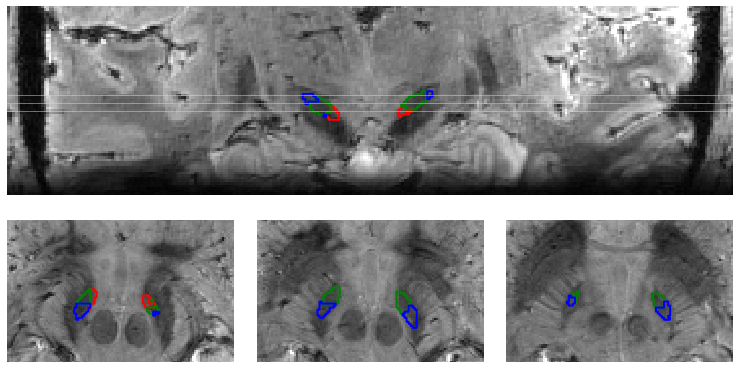

In [64]:
if ds == '02':
    bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
    vmax = 80
    space = 'T1w'
else:
    space = 'FLASH'

if mask_type == 'pca':
    save_dir = f'./derivatives/ds-{ds}/figures/pca_masks'
    subrois = ['A', 'B', 'C']
    colors = ['blue', 'green', 'red'] *2
else:
    save_dir = f'./derivatives/ds-{ds}/figures/accolla_masks'
    subrois = ['limbic', 'associative', 'motor']
    colors = ['red', 'green', 'blue'] *2
os.makedirs(save_dir, exist_ok=True)

print(subj_idx)

segment_a_l = get_mask(ds, subj_idx, space, 'l', subrois[0]).get_fdata()
segment_b_l = get_mask(ds, subj_idx, space, 'l', subrois[1]).get_fdata()
segment_c_l = get_mask(ds, subj_idx, space, 'l', subrois[2]).get_fdata()

segment_a_r = get_mask(ds, subj_idx, space, 'r', subrois[0]).get_fdata()
segment_b_r = get_mask(ds, subj_idx, space, 'r', subrois[1]).get_fdata()
segment_c_r = get_mask(ds, subj_idx, space, 'r', subrois[2]).get_fdata()

## All subrois should be in RAS - similarly, ensure background is RAS, and resample
if ds == '02':
    bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
else:
    bg_img = nilearn.image.mean_img(nilearn.image.concat_imgs(sorted(glob.glob(f'./sourcedata/sourcedata/ds-01/sub-{subj_idx}/anat/sub-{subj_idx}_echo-*_FLASH.nii.gz'))))
background_img = nilearn.image.resample_to_img(to_ras(bg_img), 
                                               target_img=get_mask(ds, subj_idx, space, 'l', subrois[1]), #nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space}_desc-stnl_subroi-B.nii.gz'), 
                                               interpolation='continuous' if ds == '01' else 'nearest')
background_data = background_img.get_fdata()
if ds == '02':
    background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map
    vox_scaler = 1
else:
    vmax = np.quantile(background_data, .985)
    vox_scaler = 1.4


## find global COM for setting figure axes limit
global_com = ndimage.center_of_mass(segment_a_l + segment_b_l + segment_c_l + segment_a_r + segment_b_r + segment_c_r)

if mask_type == 'pca':
    ap_loc = 186
    slices_ = [37, 40, 43] 
else:
    ap_loc = 185
    slices_ = [35, 38, 41] 


# plot
fig = plt.figure(tight_layout=False, figsize=(13, 7))
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0)

# top coronal slice
ax = fig.add_subplot(gs[0, :])

# com = ndimage.center_of_mass(segment_b_l.get_fdata())
plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
                                                   segment_a_r, segment_b_r, segment_c_r], segment_colors=colors, vmax=vmax,
           slices=[slice(background_data.shape[0]), int(ap_loc), slice(background_data.shape[2])], ax=ax)

for com in slices_:
    ax.axhline(y=com, color='lightgrey', linewidth=0.5)

ax.set_xlim(global_com[0]-100*vox_scaler, global_com[0]+100*vox_scaler)    # left-right: near-full FOV, 200px
ax.set_ylim(global_com[2]-25*vox_scaler, global_com[2]+27*vox_scaler)      # top-down
ax.axis('off')

# bottom row, horizontal slices
for slice_n, com in enumerate(slices_):
    ax = fig.add_subplot(gs[1, slice_n])

    plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
                                                       segment_a_r, segment_b_r, segment_c_r], segment_colors=colors, vmax=vmax,
               slices=[slice(background_data.shape[0]), slice(background_data.shape[1]), com], ax=ax,)

    ax.set_xlim(global_com[0]-40*vox_scaler, global_com[0]+40*vox_scaler)  # left-right
    ax.set_ylim(global_com[1]-20*vox_scaler, global_com[1]+30*vox_scaler)  # posterior-anterior
    ax.axis('off')
    
fig.savefig(f'./figures/{mask_type}_segments_example.pdf', bbox_inches='tight')

01


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:

No contour levels were found within the data range.



02


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:

No contour levels were found within the data range.



KeyboardInterrupt: 

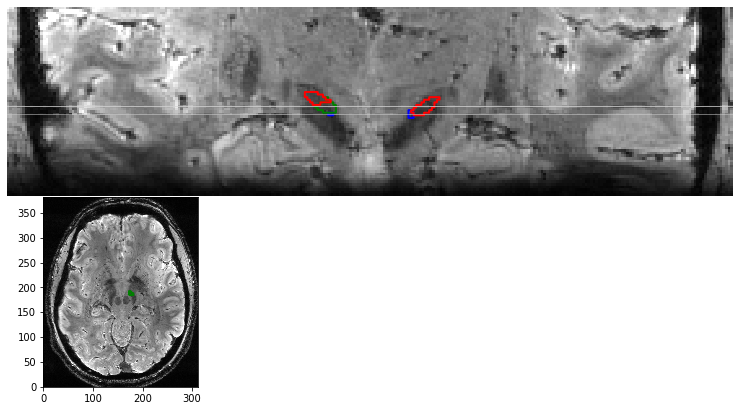

In [91]:
# # accolla masks

# # mask_type = 'pca'


# for mask_type in ['accolla', 'pca']:
#     if mask_type == 'pca':
#         save_dir = f'./derivatives/ds-{ds}/masks_warped'
#         subrois = ['A', 'B', 'C']
#     else:
#         save_dir = f'./derivatives/ds-{ds}/masks_warped_accolla'
#         subrois = ['limbic', 'associative', 'motor']

#     for ds in ['01', '02']:
#         subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]

#         if ds == '02':
#             bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
#             vmax = 80
#             space = 'T1w'
#         else:
#             # bg_img_templ =  'derivatives/ds-01/coregister_flash_to_t1w/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-mean-FLASH.nii.gz'
#             # bg_img_templ = '
#             space = 'FLASH'
#             # vmax = 900

#         for subj_idx in subject_ids:
#             print(subj_idx)

#             segment_a_l = get_mask(ds, subj_idx, space, 'l', subrois[0]).get_fdata()
#             segment_b_l = get_mask(ds, subj_idx, space, 'l', subrois[1]).get_fdata()
#             segment_c_l = get_mask(ds, subj_idx, space, 'l', subrois[2]).get_fdata()

#             segment_a_r = get_mask(ds, subj_idx, space, 'r', subrois[0]).get_fdata()
#             segment_b_r = get_mask(ds, subj_idx, space, 'r', subrois[1]).get_fdata()
#             segment_c_r = get_mask(ds, subj_idx, space, 'r', subrois[2]).get_fdata()

#             ## find global COM for setting figure axes limit
#             global_com = ndimage.center_of_mass(segment_a_l + segment_b_l + segment_c_l + segment_a_r + segment_b_r + segment_c_r)
#             com_right = ndimage.center_of_mass(segment_a_r + segment_b_r + segment_c_r)

#             com_a = np.array(ndimage.center_of_mass(segment_a_l + segment_a_r)).astype(int)
#             com_b = np.array(ndimage.center_of_mass(segment_b_l + segment_b_r)).astype(int)
#             com_c = np.array(ndimage.center_of_mass(segment_c_l + segment_c_r)).astype(int)


#             ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
#             if ds == '02':
#                 bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
#             else:
#                 bg_img = nilearn.image.mean_img(sorted(glob.glob(f'./sourcedata/sourcedata/ds-01/sub-{subj_idx}/anat/sub-{subj_idx}_echo-*_FLASH.nii.gz')))
#             background_img = nilearn.image.resample_to_img(to_ras(bg_img), 
#                                                            target_img=get_mask(ds, subj_idx, space, 'l', subrois[1]), #nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-{space}_desc-stnl_subroi-B.nii.gz'), 
#                                                            interpolation='continuous')
#             background_data = background_img.get_fdata()
#             if ds == '02':
#                 background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map
#                 vox_scaler = 1
#             else:
#                 vmax = np.quantile(background_data, .985)
#                 vox_scaler = 1.4

#             # plot
#             fig = plt.figure(tight_layout=False, figsize=(13, 7))
#             gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0)

#             # top coronal slice
#             ax = fig.add_subplot(gs[0, :])

#             # com = ndimage.center_of_mass(segment_b_l.get_fdata())
#             plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
#                                                                segment_a_r, segment_b_r, segment_c_r], 
#                        slices=[slice(background_data.shape[0]), int(com_right[1]), slice(background_data.shape[2])], ax=ax)

#             # coms_bottom = [int(ndimage.center_of_mass(x.get_fdata())[2]) for x in [segment_a_l, segment_b_l, segment_c_l]]
#             for com in [com_a, com_b, com_c]:
#                 ax.axhline(y=com[2], color='lightgrey', linewidth=0.5)

#             ax.set_xlim(global_com[0]-100*vox_scaler, global_com[0]+100*vox_scaler)    # left-right: near-full FOV, 200px
#             ax.set_ylim(global_com[2]-25*vox_scaler, global_com[2]+27*vox_scaler)      # top-down
#             ax.axis('off')

#             # bottom row, horizontal slices
#             for slice_n, com in enumerate([com_c, com_b, com_a]):
#                 ax = fig.add_subplot(gs[1, slice_n])

#                 plot_slice(bg_data=background_data, segments_data=[segment_a_l, segment_b_l, segment_c_l,
#                                                                    segment_a_r, segment_b_r, segment_c_r], 
#                            slices=[slice(background_data.shape[0]), slice(background_data.shape[1]), com[2]], ax=ax,)

#                 ax.set_xlim(global_com[0]-40*vox_scaler, global_com[0]+40*vox_scaler)  # left-right
#                 ax.set_ylim(global_com[1]-20*vox_scaler, global_com[1]+30*vox_scaler)  # posterior-anterior
#                 ax.axis('off')

#     #         break
#     #     break
#     # break
#             fig.savefig(os.path.join(save_dir, f'sub-{subj_idx}/sub-{subj_idx}_masks3.pdf'), bbox_inches='tight')
#             plt.close()

## Accolla masks

## older plotting code 

In [ ]:
# for ds in ['01', '02']:
#     subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    
#     if ds == '02':
#         bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
#         vmax = 80
#     else:
#         bg_img_templ =  'derivatives/ds-01/coregister_flash_to_t1w/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-mean-FLASH.nii.gz'
#         vmax = 900

#     for subj_idx in subject_ids:
#         print(subj_idx)

#         segment_a_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-A.nii.gz')
#         segment_b_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-B.nii.gz') 
#         segment_c_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-C.nii.gz')  

#         segment_a_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-A.nii.gz') 
#         segment_b_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-B.nii.gz') 
#         segment_c_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-C.nii.gz')    

#         ## find global COM for setting figure axes limits
#         mask_sum = nilearn.image.math_img('img*6', img=nilearn.image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn*_subroi-*.nii.gz')))
#         global_com = ndimage.center_of_mass(mask_sum.get_fdata())


#         ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
#         bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
#         background_img = nilearn.image.resample_to_img(to_ras(bg_img), target_img=segment_a_l, interpolation='nearest')
#         background_data = background_img.get_fdata()
#         if ds == '02':
#             background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map

#         f, ax = plt.subplots(2,3, figsize=(30,20))

#         for row, hemisphere in enumerate(['l', 'r']):
#             segment_b = segment_b_l if hemisphere == 'l' else segment_b_r
#             com = ndimage.center_of_mass(segment_b.get_fdata())

#             ax[row,0].imshow(background_data[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,0].contour(segment_a_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].contour(segment_a_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].set_xlim(global_com[0]-50, global_com[0]+50)    # left-right
#             ax[row,0].set_ylim(global_com[-1]-50, global_com[-1]+50)  # inferior-superior


#             ##
#             ax[row,1].imshow(background_data[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,1].contour(segment_a_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,1].contour(segment_a_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])    

#             ax[row,1].set_xlim(global_com[1]-50, global_com[1]+50)   # posterior-anterior
#             ax[row,1].set_ylim(global_com[-1]-50, global_com[-1]+50) # inferior-superior


#             ## 
#             ax[row,2].imshow(background_data[:, :, int(com[2])].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,2].contour(segment_a_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,2].contour(segment_a_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])    
#             ax[row,2].set_xlim(global_com[0]-50, global_com[0]+50)  # left-right
#             ax[row,2].set_ylim(global_com[1]-50, global_com[1]+50)  # posterior-anterior

#         f.savefig(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_PCA_masks.pdf', bbox_inches='tight')
#         plt.close()


In [ ]:
# for ds in ['01', '02']:
#     subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    
#     if ds == '02':
#         bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
#         vmax = 80
#     else:
#         bg_img_templ =  'derivatives/ds-01/coregister_flash_to_t1w/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-mean-FLASH.nii.gz'
#         vmax = 900

#     for subj_idx in subject_ids:
#         print(subj_idx)

#         segment_a_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-A.nii.gz')
#         segment_b_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-B.nii.gz') 
#         segment_c_l = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl_subroi-C.nii.gz')  

#         segment_a_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-A.nii.gz') 
#         segment_b_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-B.nii.gz') 
#         segment_c_r = nib.load(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr_subroi-C.nii.gz')    

#         ## find global COM for setting figure axes limits
#         mask_sum = nilearn.image.math_img('img*6', img=nilearn.image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn*_subroi-*.nii.gz')))
#         global_com = ndimage.center_of_mass(mask_sum.get_fdata())


#         ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
#         bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
#         background_img = nilearn.image.resample_to_img(to_ras(bg_img), target_img=segment_a_l, interpolation='nearest')
#         background_data = background_img.get_fdata()
#         if ds == '02':
#             background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map

#         f, ax = plt.subplots(2,3, figsize=(30,20))

#         for row, hemisphere in enumerate(['l', 'r']):
#             segment_b = segment_b_l if hemisphere == 'l' else segment_b_r
#             com = ndimage.center_of_mass(segment_b.get_fdata())

#             ax[row,0].imshow(background_data[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,0].contour(segment_a_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].contour(segment_a_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].set_xlim(global_com[0]-50, global_com[0]+50)    # left-right
#             ax[row,0].set_ylim(global_com[-1]-50, global_com[-1]+50)  # inferior-superior


#             ##
#             ax[row,1].imshow(background_data[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,1].contour(segment_a_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,1].contour(segment_a_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])    

#             ax[row,1].set_xlim(global_com[1]-50, global_com[1]+50)   # posterior-anterior
#             ax[row,1].set_ylim(global_com[-1]-50, global_com[-1]+50) # inferior-superior


#             ## 
#             ax[row,2].imshow(background_data[:, :, int(com[2])].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,2].contour(segment_a_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,2].contour(segment_a_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])    
#             ax[row,2].set_xlim(global_com[0]-50, global_com[0]+50)  # left-right
#             ax[row,2].set_ylim(global_com[1]-50, global_com[1]+50)  # posterior-anterior

#         f.savefig(f'./derivatives/ds-{ds}/PCA_segments/sub-{subj_idx}/sub-{subj_idx}_PCA_masks.pdf', bbox_inches='tight')
#         plt.close()


In [ ]:
# for ds in ['01', '02']:
#     subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    
#     if ds == '02':
#         bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
#         vmax = 80
#     else:
#         bg_img_templ =  'derivatives/ds-01/coregister_flash_to_t1w/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-mean-FLASH.nii.gz'
#         vmax = 900

#     for subj_idx in subject_ids:
#         print(subj_idx)

#         segment_a_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-limbic_mask.nii.gz')
#         segment_b_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-associative_mask.nii.gz') 
#         segment_c_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-motor_mask.nii.gz')  

#         segment_a_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-limbic_mask.nii.gz') 
#         segment_b_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-associative_mask.nii.gz') 
#         segment_c_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-motor_mask.nii.gz')    

#         ## find global COM for setting figure axes limits
#         mask_sum = nilearn.image.math_img('img*3', img=nilearn.image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn-*.nii.gz')))
#         global_com = ndimage.center_of_mass(mask_sum.get_fdata())


#         ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
#         bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
#         background_img = nilearn.image.resample_to_img(to_ras(bg_img), target_img=segment_a_l, interpolation='nearest')
#         background_data = background_img.get_fdata()
#         if ds == '02':
#             background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map

#         f, ax = plt.subplots(2,3, figsize=(30,20))

#         for row, hemisphere in enumerate(['l', 'r']):
#             segment_b = segment_b_l if hemisphere == 'l' else segment_b_r
#             com = ndimage.center_of_mass(segment_b.get_fdata())

#             ax[row,0].imshow(background_data[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,0].contour(segment_a_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].contour(segment_a_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,0].contour(segment_b_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,0].contour(segment_c_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].set_xlim(global_com[0]-50, global_com[0]+50)    # left-right
#             ax[row,0].set_ylim(global_com[-1]-50, global_com[-1]+50)  # inferior-superior


#             ##
#             ax[row,1].imshow(background_data[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,1].contour(segment_a_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,1].contour(segment_a_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,1].contour(segment_b_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,1].contour(segment_c_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])    

#             ax[row,1].set_xlim(global_com[1]-50, global_com[1]+50)   # posterior-anterior
#             ax[row,1].set_ylim(global_com[-1]-50, global_com[-1]+50) # inferior-superior


#             ## 
#             ax[row,2].imshow(background_data[:, :, int(com[2])].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)

#             ax[row,2].contour(segment_a_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,2].contour(segment_a_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
#             ax[row,2].contour(segment_b_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
#             ax[row,2].contour(segment_c_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])    
#             ax[row,2].set_xlim(global_com[0]-50, global_com[0]+50)  # left-right
#             ax[row,2].set_ylim(global_com[1]-50, global_com[1]+50)  # posterior-anterior
#         break
#     break
#         # f.savefig(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_masks.pdf', bbox_inches='tight')
#         # plt.close()


In [ ]:
# for ds in ['01', '02']:
#     subject_ids = [x.split('-')[-1].split('.')[0] for x in sorted(glob.glob(f'./derivatives/ds-{ds}/fmriprep/sub*.html'))]
    
#     if ds == '02':
#         bg_img_templ = './sourcedata/raw/ds-02/anat/sub-{subj_idx}/ses-1/anat/wb/source/*_mod-t2starmap*.nii'
#         vmax = 80
#     else:
#         bg_img_templ =  'derivatives/ds-01/coregister_flash_to_t1w/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-mean-FLASH.nii.gz'
#         vmax = 900

#     for subj_idx in subject_ids:
#         print(subj_idx)

#         segment_a_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-limbic_mask.nii.gz')
#         segment_b_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-associative_mask.nii.gz') 
#         segment_c_l = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnl-motor_mask.nii.gz')  

#         segment_a_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-limbic_mask.nii.gz') 
#         segment_b_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-associative_mask.nii.gz') 
#         segment_c_r = nib.load(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stnr-motor_mask.nii.gz')    

#         ## find global COM for setting figure axes limits
#         mask_sum = nilearn.image.math_img('img*3', img=nilearn.image.mean_img(glob.glob(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_space-T1w_desc-stn-*.nii.gz')))
#         global_com = ndimage.center_of_mass(mask_sum.get_fdata())
        

#         ## All subrois should be in RAS - similarly, ensure background is RAS, and resample
#         bg_img = nib.load(glob.glob(bg_img_templ.format(**locals()))[0])
#         background_img = nilearn.image.resample_to_img(to_ras(bg_img), target_img=segment_a_l, interpolation='nearest')
#         background_data = background_img.get_fdata()
#         if ds == '02':
#             background_data[background_data > vmax] = vmax    # get rid of some of the noise in the T2* map

#         f, ax = plt.subplots(2,3, figsize=(30,20))

#         segment_a_l_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_a_l.get_fdata().round()) - segment_a_l.get_fdata().round(), 0)
#         segment_b_l_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_b_l.get_fdata().round()) - segment_b_l.get_fdata().round(), 0)
#         segment_c_l_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_c_l.get_fdata().round()) - segment_c_l.get_fdata().round(), 0)
        
#         segment_a_r_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_a_r.get_fdata().round()) - segment_a_r.get_fdata().round(), 0)
#         segment_b_r_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_b_r.get_fdata().round()) - segment_b_r.get_fdata().round(), 0)
#         segment_c_r_ma = np.ma.masked_equal(ndimage.binary_dilation(segment_c_r.get_fdata().round()) - segment_c_r.get_fdata().round(), 0)

#         #plt.imshow(left_stn[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, vmin=0, vmax=1, alpha=0.5)
        
#         for row, hemisphere in enumerate(['l', 'r']):
#             segment_b = segment_b_l if hemisphere == 'l' else segment_b_r
#             com = ndimage.center_of_mass(segment_b.get_fdata())

#             ax[row,0].imshow(background_data[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)
            
#             ax[row,0].imshow(segment_a_l_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) # colors='red', levels=[0, 1])
#             ax[row,0].imshow(segment_b_l_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2) 
#             ax[row,0].imshow(segment_c_l_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2) 

#             ax[row,0].imshow(segment_a_r_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) 
#             ax[row,0].imshow(segment_b_r_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2)
#             ax[row,0].imshow(segment_c_r_ma[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2)
            
            
# #             ax[row,0].contour(segment_a_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,0].contour(segment_b_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
# #             ax[row,0].contour(segment_c_l.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

# #             ax[row,0].contour(segment_a_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,0].contour(segment_b_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
# #             ax[row,0].contour(segment_c_r.get_fdata()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

#             ax[row,0].set_xlim(global_com[0]-50, global_com[0]+50)    # left-right
#             ax[row,0].set_ylim(global_com[-1]-50, global_com[-1]+50)  # inferior-superior


#             ##
#             ax[row,1].imshow(background_data[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)
#             ax[row,1].imshow(segment_a_l_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) # colors='red', levels=[0, 1])
#             ax[row,1].imshow(segment_b_l_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2) 
#             ax[row,1].imshow(segment_c_l_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2) 

#             ax[row,1].imshow(segment_a_r_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) 
#             ax[row,1].imshow(segment_b_r_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2)
#             ax[row,1].imshow(segment_c_r_ma[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2)

# #             ax[row,1].contour(segment_a_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,1].contour(segment_b_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1]) 
# #             ax[row,1].contour(segment_c_l.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

# #             ax[row,1].contour(segment_a_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,1].contour(segment_b_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
# #             ax[row,1].contour(segment_c_r.get_fdata()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

 

# #             ## 
#             ax[row,2].imshow(background_data[:, :, int(com[2])].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=vmax)
#             ax[row,2].imshow(segment_a_l_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) # colors='red', levels=[0, 1])
#             ax[row,2].imshow(segment_b_l_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2) 
#             ax[row,2].imshow(segment_c_l_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2) 

#             ax[row,2].imshow(segment_a_r_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=2) 
#             ax[row,2].imshow(segment_b_r_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Blues, vmin=0, vmax=2)
#             ax[row,2].imshow(segment_c_r_ma[:,:, int(com[2])].T, origin='lower', cmap=plt.cm.Greens, vmin=0, vmax=2)

# #             ax[row,2].contour(segment_a_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,2].contour(segment_b_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
# #             ax[row,2].contour(segment_c_l.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])

# #             ax[row,2].contour(segment_a_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
# #             ax[row,2].contour(segment_b_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
# #             ax[row,2].contour(segment_c_r.get_fdata()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])    
#             ax[row,2].set_xlim(global_com[0]-50, global_com[0]+50)  # left-right
#             ax[row,2].set_ylim(global_com[1]-50, global_com[1]+50)  # posterior-anterior
        
#         f.savefig(f'./derivatives/ds-{ds}/masks_warped_accolla/sub-{subj_idx}/sub-{subj_idx}_masks2.pdf', bbox_inches='tight')
#         plt.close()
